In [13]:
cd /home/mil/kawana/workspace/superquadric_parsing/supershape

/home/mil/kawana/workspace/superquadric_parsing/supershape


In [14]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import math
from models import periodic_shape_sampler
from models import super_shape_sampler
from models import super_shape
import utils

scale tensor([[[1.7288, 1.5161],
         [1.6192, 1.7028]]], grad_fn=<AddBackward0>)
2 2 1000 2
/home/mil/kawana/workspace/superquadric_parsing/env/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/mil/kawana/workspace/superquadric_parsing/env/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
torch.Size([2, 2, 1000, 2])
(2, 1000, 2)


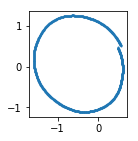

In [15]:
b = 2
n_primitives = 2
max_m = 2
thetas_points_num = 1000
points_num = 100
dim = 2
thetas = torch.linspace(0., 2. * math.pi, thetas_points_num)
points = torch.linspace(0., 2. * math.pi, points_num)
batched_points = points.view(1, -1, 1).repeat(b, 1, dim)
batched_thetas = thetas.view(1, -1).repeat(b, 1)

net = periodic_shape_sampler.PeriodicShapeSampler(points_num, n_primitives=n_primitives, max_m=max_m, factor=1, mode='delta', learn_pose=True, linear_scaling=False)

test_primitive = super_shape.SuperShapes(max_m, n_primitives)

param = test_primitive()
print('scale', param['linear_scale'])
super_shape_point, surface_mask, tsd = net(batched_points, param, thetas=batched_thetas)
print(super_shape_point.shape)
assert [*super_shape_point.shape] == [b, n_primitives, thetas_points_num, dim]
plotxy = super_shape_point[:, 0, :, :].detach().cpu().numpy()
fig = plt.figure()
g = fig.add_subplot(1, 3, 1)
g.set_aspect('equal')
print(plotxy.shape)
g.scatter(plotxy[0, :, 0], plotxy[0, :, 1], s=1)




1 2 1000 2
1 2 1000 2
1 2 1000 2
1.1165156
e2 numerator tensor([[689]])
E tensor([1.0025])
joint reg 0.05254584550857544


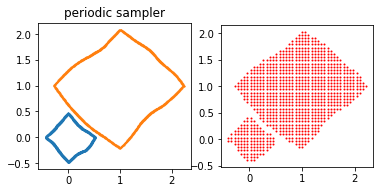

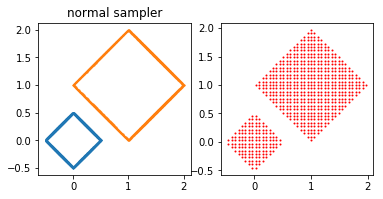

In [16]:
b = 1
linear_scaling = True
n_primitives = 2
max_m = 4
thetas_points_num = 1000
points_num = 100
dim = 2
test_thetas = torch.linspace(0., 2. * math.pi, thetas_points_num)
test_points = torch.linspace(0., 2. * math.pi, points_num)
batched_points = test_points.view(1, -1, 1).repeat(b, 1, dim)
batched_thetas = test_thetas.view(1, -1).repeat(b, 1)

test_xs, test_ys = utils.generate_grid_samples(3, batch=b, sample_num=100)
test_plot_xs = test_xs.view(-1).detach().cpu().numpy()
test_plot_ys = test_ys.view(-1).detach().cpu().numpy()

net = periodic_shape_sampler.PeriodicShapeSampler(points_num, n_primitives=n_primitives, max_m=max_m, factor=1, mode='delta', learn_pose=True, linear_scaling=linear_scaling)
net2 = super_shape_sampler.SuperShapeSampler(max_m, n_primitives, learn_pose=True, linear_scaling=linear_scaling)

param = utils.generate_multiple_primitive_params(max_m, 1, 1, 1, 1, 1, transitions=[[0., 0.], [1, 1]], linear_scales=[[1., 1.], [2., 2.]])

super_shape_point, surface_mask, tsd = net(batched_points, param, thetas=batched_thetas, xs=test_xs, ys=test_ys)

assert [*super_shape_point.shape] == [b, n_primitives, thetas_points_num, dim]
fig = plt.figure()
g = fig.add_subplot(1, 2, 1)
for idx in range(n_primitives):
  plotxy = super_shape_point[:, idx, :, :].detach().cpu().numpy()
  g.set_title('periodic sampler')
  g.set_aspect('equal')
  g.scatter(plotxy[0, :, 0], plotxy[0, :, 1], s=1)

test_plot_tsd = (nn.functional.relu(nn.functional.sigmoid(tsd*100))).sum(1).view(-1).detach().cpu().numpy()
g = fig.add_subplot(1, 2, 2)
g.set_aspect('equal')
g.scatter(test_plot_xs[test_plot_tsd>0.5], test_plot_ys[test_plot_tsd>0.5], c=[1, 0, 0], s=1)


fig2 = plt.figure()
g2 = fig2.add_subplot(1, 2, 1)
for idx in range(n_primitives):
  super_shape_point2, surface_mask2, tsd2 = net2(param, thetas=batched_thetas, xs=test_xs, ys=test_ys)
  plotxy2 = super_shape_point2[:, idx, :, :].detach().cpu().numpy()
  g2.set_title('normal sampler')
  g2.set_aspect('equal')
  g2.scatter(plotxy2[0, :, 0], plotxy2[0, :, 1], s=1)
test_plot_tsd2 = (nn.functional.relu(nn.functional.sigmoid(tsd2*100))).sum(1).view(-1).detach().cpu().numpy()
g2 = fig2.add_subplot(1, 2, 2)
g2.set_aspect('equal')
g2.scatter(test_plot_xs[test_plot_tsd2>0.5], test_plot_ys[test_plot_tsd2>0.5], c=[1, 0, 0], s=1)

print(plotxy[0, 0, 0]/plotxy2[0, 0, 0])

sigmoid_predicted_tsd = nn.functional.sigmoid(tsd2 * 100)
all_predicted_tsd = sigmoid_predicted_tsd.sum(1)

E1numerator = (sigmoid_predicted_tsd > 0.5).sum(2)
E1numerator_nonzero = torch.where(E1numerator == 0, torch.ones_like(E1numerator), E1numerator)
E1 = ( 2 * sigmoid_predicted_tsd ).sum(2) / E1numerator_nonzero
E1 = torch.where(E1numerator == 0, torch.zeros_like(E1), E1)
E2numerator =  (all_predicted_tsd > 0.5).sum(1).view(b, 1)
E2numerator_nonzero = torch.where(E2numerator == 0, torch.ones_like(E2numerator), E2numerator)
E2 = all_predicted_tsd.view(b, 1, -1).repeat(1, n_primitives, 1).clamp(max=2).sum(2) / E2numerator_nonzero
E = (E1 - E2).max(1)[0]
print('e2 numerator',  (all_predicted_tsd > 0.5).sum(1).view(b, 1))
#print('e1 bunshi', (sigmoid_predicted_tsd > 0.5).sum(2))
#print('nonzero', (sigmoid_predicted_tsd > 0.5).sum(2))
#print('E1 bunbo',  ( 2 * sigmoid_predicted_tsd ).sum(2))
print('E', E)
joint_reg = nn.functional.relu(E - 0.95).mean()
print('joint reg', joint_reg.item())